# Task 1.1: Lloyd Max algorithm
Implement the Lloyd Max algorithm for
grey value quantization. Proceed as follows:


In [1]:
from itertools import islice
import scipy.misc as misc
import numpy as np
import matplotlib.pyplot as plt


def readImage(filename):
    f = misc.imread(filename, flatten=True).astype("float")
    return f


## Read gray images

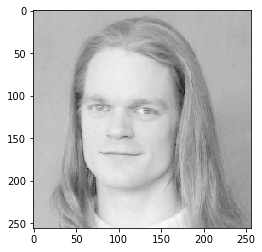

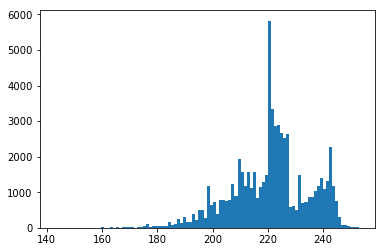

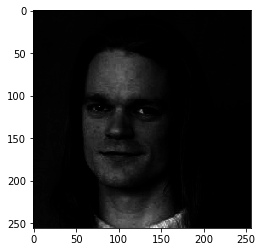

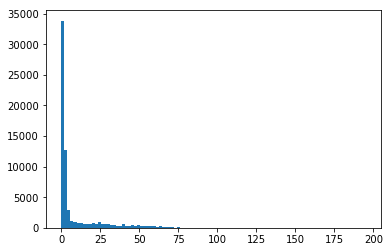

In [3]:
bauckhage_gamma_1 = readImage('images/bauckhage-gamma-1.png')
bauckhage_gamma_2 = readImage('images/bauckhage-gamma-2.png')

plt.figure()
plt.imshow(bauckhage_gamma_1, cmap='gray')
plt.figure()
plt.hist(bauckhage_gamma_1.ravel(), bins=100)

plt.figure()
plt.imshow(bauckhage_gamma_2, cmap='gray')
plt.figure()
plt.hist(bauckhage_gamma_2.ravel(), bins=100)
plt.show()

## Utilities


In [3]:
def window(seq, n=2):
    """
    Function taken from Python docs
    Returns a sliding window (of width n) over data from the iterable
    """
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def plotStep(boundaries, pointsBv):
    plt.figure()
    plt.step(boundaries, np.insert(pointsBv, 0, 0))#,where='mid')
    plt.xlim(0, 256)
    plt.ylim(0, 256)
    plt.xticks(np.arange(0, 257, 32))
    plt.show()

## Lloyd Algorithm function

In [4]:
def compute_error(boundaries, pointsBv, probs):
    error = 0
    for (current, incoming), pv in zip(window(boundaries, 2), pointsBv):
        for j in range(int(current), int(incoming)):
            error += (j-pv) * (j-pv) * probs[j]
    print ("Computed Error: ", error)
    return error

def initQuantization(imgData, levels, initType=1):
    '''
    * Compute density distribution of histogram
    * Compute initial boundaries and quantization points
    * Type = 1: min=0, max=256
    * Type = 2: min=min(image), max=max(image)
    '''
    # first calculate the intensity histogram
    histogram = np.histogram(imgData, bins=np.arange(257))[0]

    # calculate PDF
    probs = histogram/histogram.sum()
    
    # initialize the boundaries and quantization points
    if initType == 1:
        boundaries = np.arange(levels+1) * 256/levels
    elif initType == 2:
        mid_bound = ((np.arange(levels-1) + 1) * (np.max(imgData)-np.min(imgData))/levels) + np.min(imgData)
        mid_bound = mid_bound.tolist()
        boundaries = np.array( [np.min(imgData)] + mid_bound + [np.max(imgData)] )
    
    pointsBv = np.zeros(levels)
    for i, (current, incoming) in enumerate(window(boundaries, 2)):
        pointsBv[i] = (current + incoming) / 2.
    
    print ("#------ Initilization ")
    print (np.sum(probs), probs.shape)
    print ("Init Boundaries: ", boundaries)
    print ("Init Certer Points: ", pointsBv)
    return (probs, boundaries, pointsBv)

In [5]:
def lloydAlgorithm(imgData, levels=2, initType=1, maxIterations =200, errorThreshold=10, improveThreshold=0.0001):
    """Implement the Lloyd Max quantization algorithm"""
    # Init computation
    (probs, boundaries, pointsBv) = initQuantization(imgData, levels, initType)

    #iterate the equations
    currentError = compute_error(boundaries, pointsBv, probs)

    iterationCount = 0
    stopFlag = False
    while (stopFlag == False):
        iterationCount += 1
        print ("\nIteration:", iterationCount)

        #update boundaries
        for i in range(1, levels):
            if (pointsBv[i-1] != 0 and pointsBv[i] != 0):
#             if (pointsBv[i] > pointsBv[i-1]):
                boundaries[i] = (pointsBv[i] + pointsBv[i-1])/2.0
        print ("Boundaries:", boundaries)

        #update points
        for i, (current, incoming) in enumerate(window(boundaries, 2)):
            numerator = 0.0
            denominator = 0.0
            for j in range(int(current), int(incoming)):
                numerator += j*probs[j]
                denominator += probs[j]
            if(numerator==0 or denominator==0):
                pointsBv[i] = 0.0
            else:
                pointsBv[i] = float(numerator)/float(denominator)    
        print ("Points:", pointsBv)

        # compute error
        prevError = currentError
        currentError = compute_error(boundaries, pointsBv, probs)

        if (iterationCount >= maxIterations 
            or currentError <= errorThreshold
            or abs(1. - currentError/prevError) < improveThreshold):
            print ("Final Error :", currentError, "Improvement Ratio: ", abs(1. - currentError/prevError))
            stopFlag = True
    
    rows, cols = imgData.shape
    newImgData = np.ndarray(shape=(rows, cols))
    for i in range(rows):
        for j in range(cols):
            for k in range(levels):
                if(imgData[i,j]>=boundaries[k] and imgData[i,j]<boundaries[k+1]):
                    break
            newImgData[i,j] = pointsBv[k]
    
    plt.imshow(imgData, cmap='gray')
    plt.show()
    plt.imshow(newImgData, cmap='gray')
    plt.show()
    plotStep(boundaries, pointsBv)
    
    return newImgData, boundaries, pointsBv

## Histogram of Images

## Result - bauckhage_gamma_1

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.  128.  256.]
Init Certer Points:  [  64.  192.]
Computed Error:  1026.19595337

Iteration: 1
Boundaries: [   0.  128.  256.]
Points: [   0.          220.79052734]
Computed Error:  197.301488638

Iteration: 2
Boundaries: [   0.  128.  256.]
Points: [   0.          220.79052734]
Computed Error:  197.301488638
Final Error : 197.301488638 Improvement Ratio:  0.0


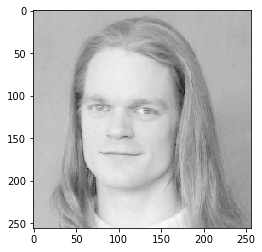

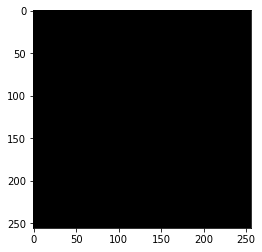

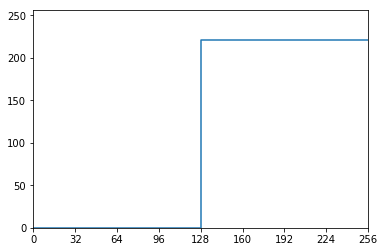

(array([[ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734],
        [ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734],
        [ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734],
        ..., 
        [ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734],
        [ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734],
        [ 220.79052734,  220.79052734,  220.79052734, ...,  220.79052734,
          220.79052734,  220.79052734]]),
 array([   0.,  128.,  256.]),
 array([   0.        ,  220.79052734]))

In [6]:
lloydAlgorithm(bauckhage_gamma_1, levels=2, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   64.  128.  192.  256.]
Init Certer Points:  [  32.   96.  160.  224.]
Computed Error:  178.063140869

Iteration: 1
Boundaries: [   0.   64.  128.  192.  256.]
Points: [   0.            0.          183.6809681   221.84933614]
Computed Error:  158.00956098

Iteration: 2
Boundaries: [   0.           64.          128.          202.76515212  256.        ]
Points: [   0.            0.          193.54149766  223.74466394]
Computed Error:  116.80413289

Iteration: 3
Boundaries: [   0.          64.         128.         208.6430808  256.       ]
Points: [   0.            0.          198.38550543  225.38341883]
Computed Error:  94.3976541867

Iteration: 4
Boundaries: [   0.           64.          128.          211.88446213  256.        ]
Points: [   0.            0.          200.53531811  226.27946396]
Computed Error:  86.1219290908

Iteration: 5
Boundaries: [   0.           64.          128.          213.40739104  256.        ]
Points:

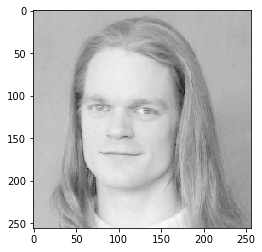

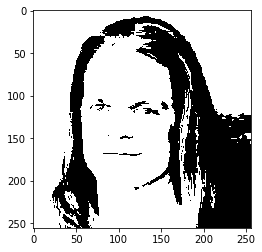

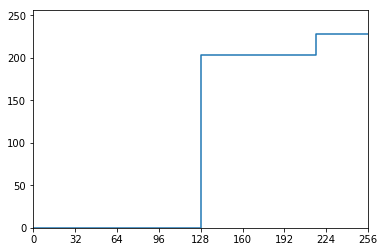

(array([[ 227.90501159,  227.90501159,  227.90501159, ...,  227.90501159,
          227.90501159,  227.90501159],
        [ 227.90501159,  227.90501159,  227.90501159, ...,  227.90501159,
          227.90501159,  227.90501159],
        [ 227.90501159,  227.90501159,  227.90501159, ...,  227.90501159,
          227.90501159,  227.90501159],
        ..., 
        [ 227.90501159,  227.90501159,  227.90501159, ...,  203.85017799,
          203.85017799,  203.85017799],
        [ 227.90501159,  227.90501159,  227.90501159, ...,  203.85017799,
          203.85017799,  203.85017799],
        [ 227.90501159,  227.90501159,  227.90501159, ...,  203.85017799,
          203.85017799,  203.85017799]]),
 array([   0.        ,   64.        ,  128.        ,  215.87759479,  256.        ]),
 array([   0.        ,    0.        ,  203.85017799,  227.90501159]))

In [7]:
lloydAlgorithm(bauckhage_gamma_1, levels=4, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   32.   64.   96.  128.  160.  192.  224.  256.]
Init Certer Points:  [  16.   48.   80.  112.  144.  176.  208.  240.]
Computed Error:  98.7213439941

Iteration: 1
Boundaries: [   0.   32.   64.   96.  128.  160.  192.  224.  256.]
Points: [   0.            0.            0.            0.          155.5
  183.80552486  213.1286693   233.10793902]
Computed Error:  62.4532937566

Iteration: 2
Boundaries: [   0.           32.           64.           96.          128.
  169.65276243  198.46709708  223.11830416  256.        ]
Points: [   0.            0.            0.            0.          162.98630137
  190.06694781  213.42847     232.16244052]
Computed Error:  52.7623074611

Iteration: 3
Boundaries: [   0.           32.           64.           96.          128.
  176.52662459  201.74770891  222.79545526  256.        ]
Points: [   0.            0.            0.            0.          169.70517928
  193.65011038  213.33743566  231.

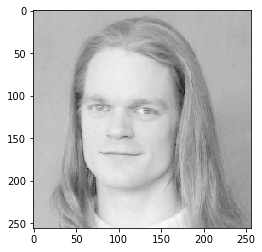

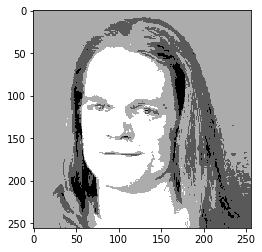

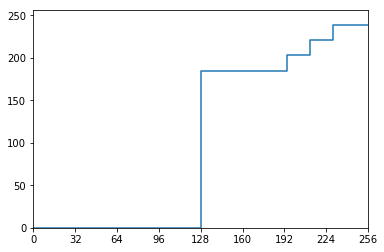

(array([[ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        ..., 
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555]]),
 array([   0.        ,   32.        ,   64.        ,   96.        ,
         128.        ,  193.78836473,  211.92431945,  229.4489189 ,  256.        ]),
 array([   0.        ,    0.        ,    0.        ,    0.        ,
         184.36932392,  203.20740555,  220.64123335,  238.25660446]))

In [8]:
lloydAlgorithm(bauckhage_gamma_1, levels=8, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.]
Init Certer Points:  [   8.   24.   40.   56.   72.   88.  104.  120.  136.  152.  168.  184.
  200.  216.  232.  248.]
Computed Error:  26.5245666504

Iteration: 1
Boundaries: [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.]
Points: [   0.            0.            0.            0.            0.            0.
    0.            0.          143.          157.28571429  170.17283951
  185.91959158  201.25045547  217.29934149  229.77832632  242.72801007]
Computed Error:  20.9191616211

Iteration: 2
Boundaries: [   0.           16.           32.           48.           64.           80.
   96.          112.          128.          150.14285714  163.7292769
  178.04621554  193.58502352  209.27489848  223.5388339   236.25316819
  256.        ]
Points: [   0.            0.            0.

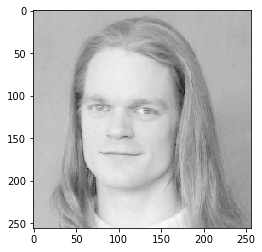

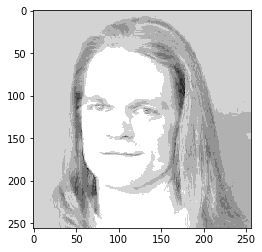

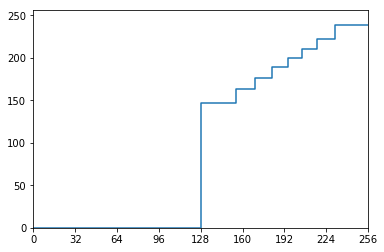

(array([[ 222.67869332,  222.67869332,  222.67869332, ...,  222.67869332,
          222.67869332,  222.67869332],
        [ 222.67869332,  222.67869332,  222.67869332, ...,  222.67869332,
          222.67869332,  222.67869332],
        [ 222.67869332,  222.67869332,  222.67869332, ...,  222.67869332,
          222.67869332,  222.67869332],
        ..., 
        [ 222.67869332,  222.67869332,  222.67869332, ...,  210.59426752,
          210.59426752,  210.59426752],
        [ 222.67869332,  222.67869332,  222.67869332, ...,  210.59426752,
          210.59426752,  210.59426752],
        [ 222.67869332,  222.67869332,  222.67869332, ...,  210.59426752,
          210.59426752,  210.59426752]]),
 array([   0.        ,   16.        ,   32.        ,   48.        ,
          64.        ,   80.        ,   96.        ,  112.        ,
         128.        ,  155.21830986,  169.85056792,  182.69919573,
         194.45905039,  205.18924648,  216.63648042,  230.64891095,  256.        ]),
 array([   

In [9]:
lloydAlgorithm(bauckhage_gamma_1, levels=16, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.]
Init Certer Points:  [   4.   12.   20.   28.   36.   44.   52.   60.   68.   76.   84.   92.
  100.  108.  116.  124.  132.  140.  148.  156.  164.  172.  180.  188.
  196.  204.  212.  220.  228.  236.  244.  252.]
Computed Error:  5.38491821289

Iteration: 1
Boundaries: [   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.]
Points: [   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.          143.
  151.          158.33333333  1

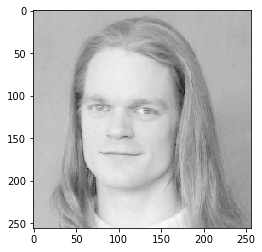

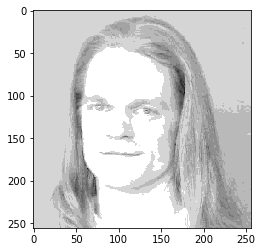

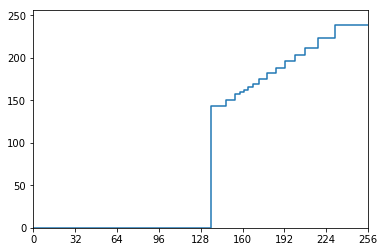

(array([[ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        ..., 
        [ 222.87995982,  222.87995982,  222.87995982, ...,  203.95183486,
          203.95183486,  203.95183486],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  203.95183486,
          203.95183486,  203.95183486],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  203.95183486,
          203.95183486,  212.17411344]]),
 array([   0.        ,    8.        ,   16.        ,   24.        ,
          32.        ,   40.        ,   48.        ,   56.        ,
          64.        ,   72.        ,   80.        ,   88.        ,
          96.        ,  104.        ,  112.        ,  120.        ,
         128.        ,  136.

In [10]:
lloydAlgorithm(bauckhage_gamma_1, levels=32, initType=1, maxIterations=200, errorThreshold=1., improveThreshold=0.0001)

## Result - bauckhage_gamma_2

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.  128.  256.]
Init Certer Points:  [  64.  192.]
Computed Error:  3370.6194458

Iteration: 1
Boundaries: [   0.  128.  256.]
Points: [   8.07516914  150.31578947]
Computed Error:  244.241704304

Iteration: 2
Boundaries: [   0.           79.19547931  256.        ]
Points: [   7.75396996  106.26013514]
Computed Error:  218.194808065

Iteration: 3
Boundaries: [   0.           57.00705255  256.        ]
Points: [  6.45131439  70.79325843]
Computed Error:  152.435574325

Iteration: 4
Boundaries: [   0.           38.62228641  256.        ]
Points: [  4.32952535  54.55377302]
Computed Error:  82.4598930557

Iteration: 5
Boundaries: [   0.           29.44164919  256.        ]
Points: [  3.31369359  48.08446371]
Computed Error:  66.9749250167

Iteration: 6
Boundaries: [   0.           25.69907865  256.        ]
Points: [  2.8668168   45.20293191]
Computed Error:  64.5155034549

Iteration: 7
Boundaries: [   0.           24.03487436  256. 

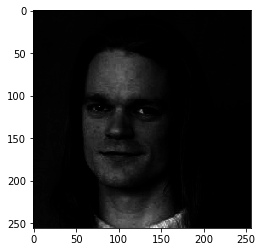

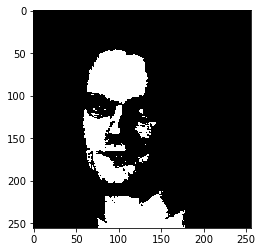

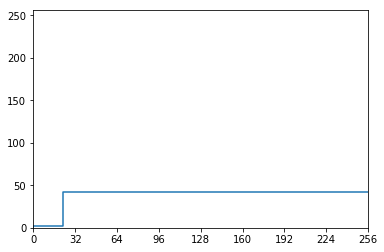

(array([[ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        ..., 
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832]]),
 array([   0.        ,   22.40660966,  256.        ]),
 array([  2.42468832,  42.388531  ]))

In [11]:
lloydAlgorithm(bauckhage_gamma_2, levels=2, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   64.  128.  192.  256.]
Init Certer Points:  [  32.   96.  160.  224.]
Computed Error:  795.398742676

Iteration: 1
Boundaries: [   0.   64.  128.  192.  256.]
Points: [   7.11839232   75.6619256   149.51785714  195.        ]
Computed Error:  179.601494236

Iteration: 2
Boundaries: [   0.           41.39015896  112.58989137  172.25892857  256.        ]
Points: [   4.81808254   55.82198825  131.44318182  181.58333333]
Computed Error:  83.8910650217

Iteration: 3
Boundaries: [   0.           30.32003539   93.63258503  156.51325758  256.        ]
Points: [   3.4362908    46.94728196  115.78205128  174.26315789]
Computed Error:  52.5672119349

Iteration: 4
Boundaries: [   0.           25.19178638   81.36466662  145.02260459  256.        ]
Points: [   2.8668168    43.10779042  104.34763948  169.125     ]
Computed Error:  45.9193038366

Iteration: 5
Boundaries: [   0.           22.98730361   73.72771495  136.73631974  256.        ]


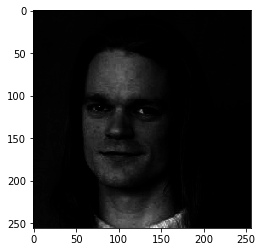

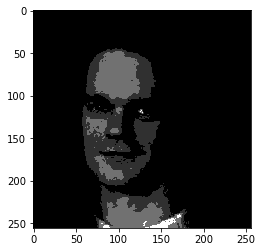

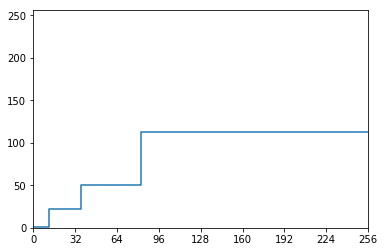

(array([[ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        ..., 
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556]]),
 array([   0.        ,   12.05611917,   36.79389751,   82.11911351,  256.        ]),
 array([   1.47634556,   22.63589279,   50.95190223,  113.28632479]))

In [12]:
lloydAlgorithm(bauckhage_gamma_2, levels=4, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   32.   64.   96.  128.  160.  192.  224.  256.]
Init Certer Points:  [  16.   48.   80.  112.  144.  176.  208.  240.]
Computed Error:  187.503234863

Iteration: 1
Boundaries: [   0.   32.   64.   96.  128.  160.  192.  224.  256.]
Points: [   3.68860293   45.09554974   71.16440049  110.31428571  139.63414634
  176.53333333  195.            0.        ]
Computed Error:  48.8759921423

Iteration: 2
Boundaries: [   0.           24.39207634   58.12997512   90.7393431   124.97421603
  158.08373984  185.76666667  224.          256.        ]
Points: [   2.63519881   37.54930347   66.38495252  105.67521368  136.96078431
  172.          190.2           0.        ]
Computed Error:  31.1967280677

Iteration: 3
Boundaries: [   0.           20.09225114   51.96712799   86.0300831   121.31799899
  154.48039216  181.1         224.          256.        ]
Points: [   2.16584942   32.57453376   61.16556873  100.32624113  133.75438596
  167.61538

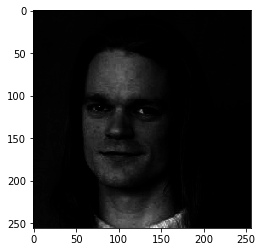

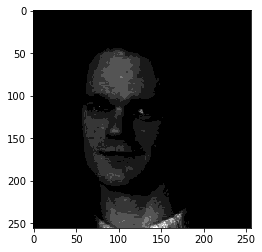

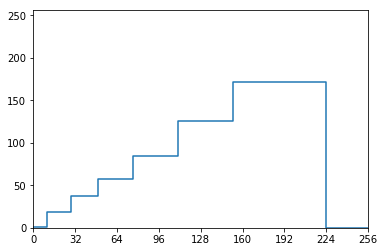

(array([[ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        ..., 
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015]]),
 array([   0.        ,   10.13570312,   29.04923142,   49.80947745,
          75.867288  ,  110.86083132,  152.35760634,  224.        ,  256.        ]),
 array([   1.32693015,   18.52698695,   37.44221224,   58.0003962 ,
          84.56293706,  126.30337079,  172.14285714,    0.        ]))

In [13]:
lloydAlgorithm(bauckhage_gamma_2, levels=8, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.]
Init Certer Points:  [   8.   24.   40.   56.   72.   88.  104.  120.  136.  152.  168.  184.
  200.  216.  232.  248.]
Computed Error:  42.2005004883

Iteration: 1
Boundaries: [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.]
Points: [   1.79396827   23.08730309   39.26448956   55.26475115   69.11904762
   86.53684211  103.30645161  120.41860465  134.65384615  148.26666667
  168.57142857  183.5         195.            0.            0.            0.        ]
Computed Error:  10.2862562091

Iteration: 2
Boundaries: [   0.           12.44063568   31.17589632   47.26462036   62.19189939
   77.82794486   94.92164686  111.86252813  127.5362254   141.46025641
  158.41904762  176.03571429  189.25        208.          224.          240.
  256.        ]
Points: [   1.47634556   20.56474

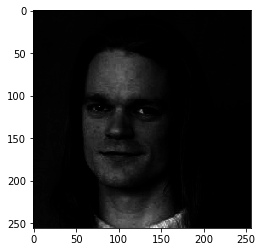

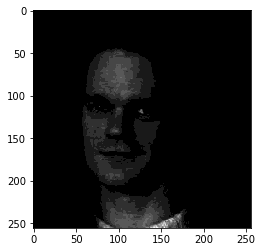

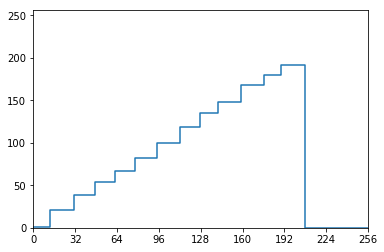

(array([[ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        ..., 
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556]]),
 array([   0.        ,   12.44063568,   31.17589632,   47.26462036,
          62.19189939,   77.82794486,   94.92164686,  111.86252813,
         127.5362254 ,  141.46025641,  158.41904762,  176.03571429,
         189.25      ,  208.        ,  224.        ,  240.        ,  256.        ]),
 array([   1.47634556,   20.56474429,   38.05065502,   53.63833992,
          66.92

In [14]:
lloydAlgorithm(bauckhage_gamma_2, levels=16, initType=1)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.]
Init Certer Points:  [   4.   12.   20.   28.   36.   44.   52.   60.   68.   76.   84.   92.
  100.  108.  116.  124.  132.  140.  148.  156.  164.  172.  180.  188.
  196.  204.  212.  220.  228.  236.  244.  252.]
Computed Error:  9.21734619141

Iteration: 1
Boundaries: [   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.]
Points: [   1.190964     11.09683313   19.36306672   27.04029734   35.58766756
   43.73468057   52.1245614    59.68974042   66.60714286   75.14761905
   83.33928571   91.12820513   99.36363636  107.79310345  115.4
  123.10714286  131.38461538  137.92307692  145.2       

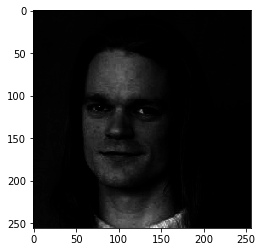

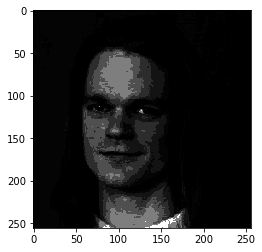

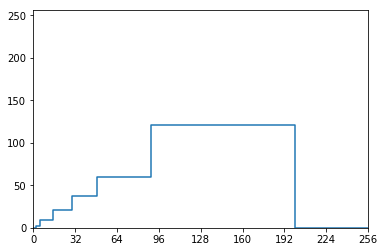

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ]]),
 array([   0.        ,    1.73156106,    1.9948518 ,    1.9948518 ,
           1.9948518 ,    1.93195629,    1.93195629,    1.93195629,
           1.9948518 ,    1.9948518 ,    1.9948518 ,    1.9948518 ,
           1.9948518 ,    1.9948518 ,    1.93195629,    1.93195629,
           1.93195629,    1.93195629,    1.9948518 ,    1.9948518 ,
           5.48607172,   15.2230

In [15]:
lloydAlgorithm(bauckhage_gamma_2, levels=32, initType=1, maxIterations=200, errorThreshold=1., improveThreshold=0.0001)

## Result - bauckhage_gamma_1 with different initial

#------ Initilization 
1.0 (256,)
Init Boundaries:  [ 143.  198.  253.]
Init Certer Points:  [ 170.5  225.5]
Computed Error:  164.660427094

Iteration: 1
Boundaries: [ 143.  198.  253.]
Points: [ 189.55572795  222.74863787]
Computed Error:  136.111013431

Iteration: 2
Boundaries: [ 143.          206.15218291  253.        ]
Points: [ 196.5794137   224.71487596]
Computed Error:  102.264287357

Iteration: 3
Boundaries: [ 143.          210.64714483  253.        ]
Points: [ 199.83474251  225.98048548]
Computed Error:  88.5199233094

Iteration: 4
Boundaries: [ 143.          212.90761399  253.        ]
Points: [ 201.58811792  226.75657513]
Computed Error:  82.7184088515

Iteration: 5
Boundaries: [ 143.          214.17234653  253.        ]
Points: [ 203.23539068  227.57876807]
Computed Error:  78.1136914854

Iteration: 6
Boundaries: [ 143.          215.40707937  253.        ]
Points: [ 203.85017799  227.90446785]
Computed Error:  76.7700304507

Iteration: 7
Boundaries: [ 143.          215.8773

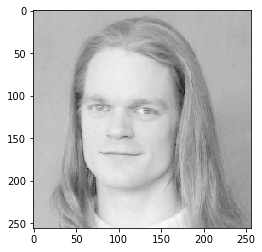

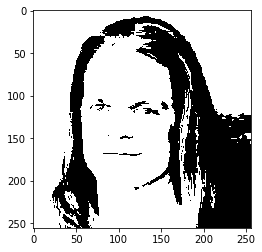

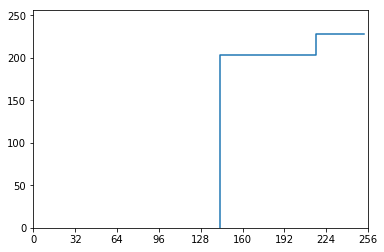

(array([[ 227.90446785,  227.90446785,  227.90446785, ...,  227.90446785,
          227.90446785,  227.90446785],
        [ 227.90446785,  227.90446785,  227.90446785, ...,  227.90446785,
          227.90446785,  227.90446785],
        [ 227.90446785,  227.90446785,  227.90446785, ...,  227.90446785,
          227.90446785,  227.90446785],
        ..., 
        [ 227.90446785,  227.90446785,  227.90446785, ...,  203.85017799,
          203.85017799,  203.85017799],
        [ 227.90446785,  227.90446785,  227.90446785, ...,  203.85017799,
          203.85017799,  203.85017799],
        [ 227.90446785,  227.90446785,  227.90446785, ...,  203.85017799,
          203.85017799,  203.85017799]]),
 array([ 143.        ,  215.87732292,  253.        ]),
 array([ 203.85017799,  227.90446785]))

In [16]:
lloydAlgorithm(bauckhage_gamma_1, levels=2, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [ 143.   170.5  198.   225.5  253. ]
Init Certer Points:  [ 156.75  184.25  211.75  239.25]
Computed Error:  69.9380941391

Iteration: 1
Boundaries: [ 143.   170.5  198.   225.5  253. ]
Points: [ 164.37894737  190.18981972  215.0047365   234.15887213]
Computed Error:  52.0243733262

Iteration: 2
Boundaries: [ 143.          177.28438355  202.59727811  224.58180432  253.        ]
Points: [ 170.6440678   194.64611611  215.42853037  233.10722376]
Computed Error:  44.0739842543

Iteration: 3
Boundaries: [ 143.          182.64509195  205.03732324  224.26787707  253.        ]
Points: [ 174.46282528  197.27850038  216.24901172  233.10722376]
Computed Error:  39.9057196313

Iteration: 4
Boundaries: [ 143.          185.87066283  206.76375605  224.67811774  253.        ]
Points: [ 177.44814815  198.43927028  216.5489119   233.10722376]
Computed Error:  38.3301387465

Iteration: 5
Boundaries: [ 143.          187.94370922  207.49409109  224.828067

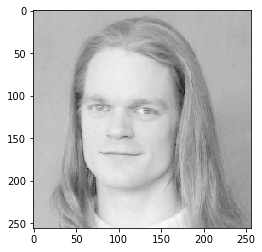

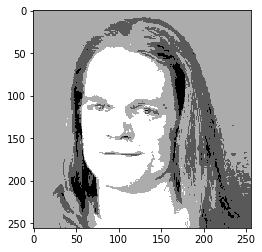

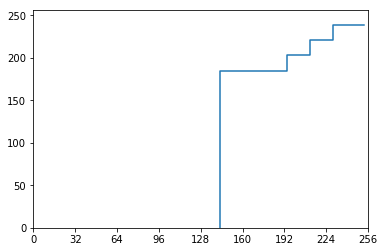

(array([[ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  220.64123335,
          220.64123335,  220.64123335],
        ..., 
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555],
        [ 220.64123335,  220.64123335,  220.64123335, ...,  203.20740555,
          203.20740555,  203.20740555]]),
 array([ 143.        ,  193.78836473,  211.92431945,  229.44847222,  253.        ]),
 array([ 184.36932392,  203.20740555,  220.64123335,  238.25571108]))

In [17]:
lloydAlgorithm(bauckhage_gamma_1, levels=4, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [ 143.    156.75  170.5   184.25  198.    211.75  225.5   239.25  253.  ]
Init Certer Points:  [ 149.875  163.625  177.375  191.125  204.875  218.625  232.375  246.125]
Computed Error:  19.0955121517

Iteration: 1
Boundaries: [ 143.    156.75  170.5   184.25  198.    211.75  225.5   239.25  253.  ]
Points: [ 147.          164.75268817  177.87366548  192.34610592  204.73659212
  218.90146451  230.0073848   242.11746812]
Computed Error:  15.4882543635

Iteration: 2
Boundaries: [ 143.          155.87634409  171.31317683  185.1098857   198.54134902
  211.81902832  224.45442466  236.06242646  253.        ]
Points: [ 147.          165.71929825  179.46253602  192.76382074  204.73659212
  218.2834407   227.61180966  240.8018469 ]
Computed Error:  12.7749622384

Iteration: 3
Boundaries: [ 143.          156.35964912  172.59091713  186.11317838  198.75020643
  211.51001641  222.94762518  234.20682828  253.        ]
Points: [ 147.          166.79

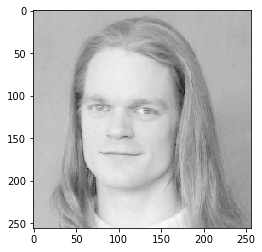

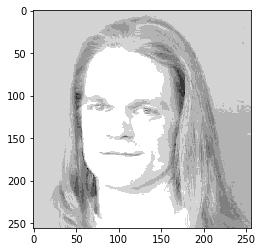

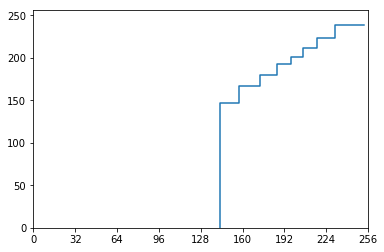

(array([[ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  222.87995982,
          222.87995982,  222.87995982],
        ..., 
        [ 222.87995982,  222.87995982,  222.87995982, ...,  201.49891775,
          201.49891775,  211.29086881],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  211.29086881,
          211.29086881,  211.29086881],
        [ 222.87995982,  222.87995982,  222.87995982, ...,  211.29086881,
          211.29086881,  211.29086881]]),
 array([ 143.        ,  156.8951049 ,  173.57906716,  186.46596153,
         197.03145814,  206.39489328,  217.08541431,  230.74909143,  253.        ]),
 array([ 147.        ,  166.79020979,  180.36792453,  192.56399852,
         201.49891775,  211.29086881,  222.87995982,  238.61822303]))

In [18]:
lloydAlgorithm(bauckhage_gamma_1, levels=8, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [ 143.     149.875  156.75   163.625  170.5    177.375  184.25   191.125
  198.     204.875  211.75   218.625  225.5    232.375  239.25   246.125
  253.   ]
Init Certer Points:  [ 146.4375  153.3125  160.1875  167.0625  173.9375  180.8125  187.6875
  194.5625  201.4375  208.3125  215.1875  222.0625  228.9375  235.8125
  242.6875  249.5625]
Computed Error:  4.90970414877

Iteration: 1
Boundaries: [ 143.     149.875  156.75   163.625  170.5    177.375  184.25   191.125
  198.     204.875  211.75   218.625  225.5    232.375  239.25   246.125
  253.   ]
Points: [ 143.          151.          160.15384615  166.53731343  173.62
  180.22375691  187.59318637  194.49050633  200.5730035   207.16095193
  213.78336687  221.49061298  226.82744141  235.30642799  241.76505195
  247.16308244]
Computed Error:  3.50515741107
Final Error : 3.50515741107 Improvement Ratio:  0.286075636156


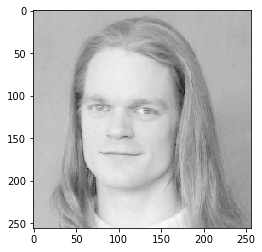

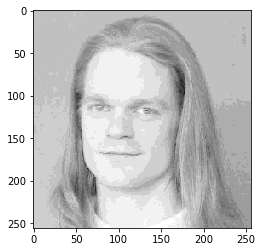

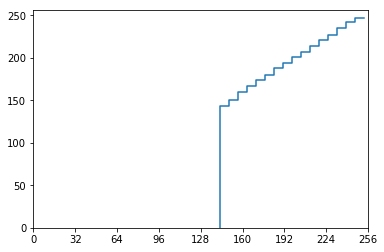

(array([[ 221.49061298,  221.49061298,  221.49061298, ...,  221.49061298,
          221.49061298,  221.49061298],
        [ 221.49061298,  221.49061298,  221.49061298, ...,  221.49061298,
          221.49061298,  221.49061298],
        [ 221.49061298,  221.49061298,  221.49061298, ...,  221.49061298,
          221.49061298,  221.49061298],
        ..., 
        [ 226.82744141,  226.82744141,  226.82744141, ...,  207.16095193,
          207.16095193,  207.16095193],
        [ 226.82744141,  226.82744141,  226.82744141, ...,  207.16095193,
          207.16095193,  207.16095193],
        [ 226.82744141,  226.82744141,  226.82744141, ...,  207.16095193,
          207.16095193,  207.16095193]]),
 array([ 143.   ,  149.875,  156.75 ,  163.625,  170.5  ,  177.375,
         184.25 ,  191.125,  198.   ,  204.875,  211.75 ,  218.625,
         225.5  ,  232.375,  239.25 ,  246.125,  253.   ]),
 array([ 143.        ,  151.        ,  160.15384615,  166.53731343,
         173.62      ,  180.22375691

In [19]:
lloydAlgorithm(bauckhage_gamma_1, levels=16, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [ 143.      146.4375  149.875   153.3125  156.75    160.1875  163.625
  167.0625  170.5     173.9375  177.375   180.8125  184.25    187.6875
  191.125   194.5625  198.      201.4375  204.875   208.3125  211.75
  215.1875  218.625   222.0625  225.5     228.9375  232.375   235.8125
  239.25    242.6875  246.125   249.5625  253.    ]
Init Certer Points:  [ 144.71875  148.15625  151.59375  155.03125  158.46875  161.90625
  165.34375  168.78125  172.21875  175.65625  179.09375  182.53125
  185.96875  189.40625  192.84375  196.28125  199.71875  203.15625
  206.59375  210.03125  213.46875  216.90625  220.34375  223.78125
  227.21875  230.65625  234.09375  237.53125  240.96875  244.40625
  247.84375  251.28125]
Computed Error:  1.83073793352

Iteration: 1
Boundaries: [ 143.      146.4375  149.875   153.3125  156.75    160.1875  163.625
  167.0625  170.5     173.9375  177.375   180.8125  184.25    187.6875
  191.125   194.5625  198.      201.4

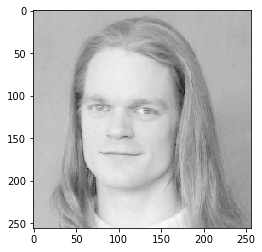

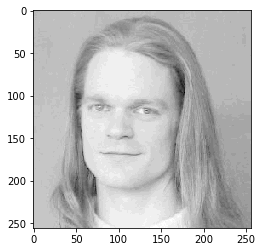

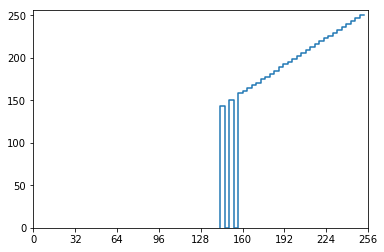

(array([[ 219.95097014,  219.95097014,  219.95097014, ...,  219.95097014,
          219.95097014,  219.95097014],
        [ 219.95097014,  219.95097014,  219.95097014, ...,  219.95097014,
          219.95097014,  219.95097014],
        [ 219.95097014,  219.95097014,  219.95097014, ...,  219.95097014,
          219.95097014,  219.95097014],
        ..., 
        [ 225.99629819,  225.99629819,  225.99629819, ...,  205.68537749,
          205.68537749,  205.68537749],
        [ 225.99629819,  225.99629819,  225.99629819, ...,  205.68537749,
          205.68537749,  205.68537749],
        [ 225.99629819,  225.99629819,  225.99629819, ...,  205.68537749,
          205.68537749,  209.02266289]]),
 array([ 143.    ,  146.4375,  149.875 ,  153.3125,  156.75  ,  160.1875,
         163.625 ,  167.0625,  170.5   ,  173.9375,  177.375 ,  180.8125,
         184.25  ,  187.6875,  191.125 ,  194.5625,  198.    ,  201.4375,
         204.875 ,  208.3125,  211.75  ,  215.1875,  218.625 ,  222.0625,
    

In [20]:
lloydAlgorithm(bauckhage_gamma_1, levels=32, initType=2, maxIterations=200, errorThreshold=1., improveThreshold=0.0001)

## Result - bauckhage_gamma_2 with different initial

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.    97.5  195. ]
Init Certer Points:  [  48.75  146.25]
Computed Error:  1893.17907619

Iteration: 1
Boundaries: [   0.    97.5  195. ]
Points: [   7.92308398  125.60526316]
Computed Error:  229.244880755

Iteration: 2
Boundaries: [   0.           66.76417357  195.        ]
Points: [  7.24672776  82.74757282]
Computed Error:  190.52002319

Iteration: 3
Boundaries: [   0.           44.99715029  195.        ]
Points: [  5.14035003  59.94444444]
Computed Error:  103.166775242

Iteration: 4
Boundaries: [   0.           32.54239724  195.        ]
Points: [  3.68860293  50.44301994]
Computed Error:  70.8686649368

Iteration: 5
Boundaries: [   0.           27.06581144  195.        ]
Points: [  3.07813635  46.56333463]
Computed Error:  64.934208542

Iteration: 6
Boundaries: [   0.           24.82073549  195.        ]
Points: [  2.63519881  43.70227631]
Computed Error:  63.8497768174

Iteration: 7
Boundaries: [   0.           23.16873756

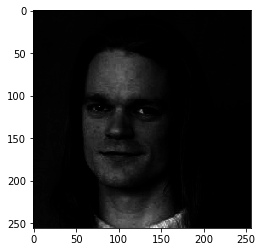

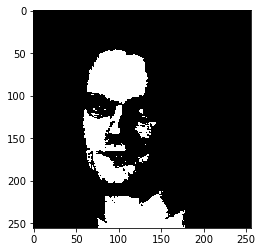

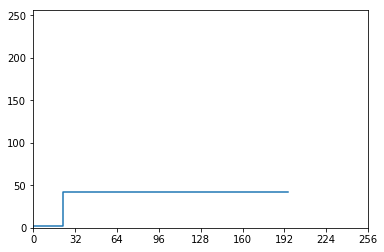

(array([[ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        ..., 
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832],
        [ 2.42468832,  2.42468832,  2.42468832, ...,  2.42468832,
          2.42468832,  2.42468832]]),
 array([   0.        ,   22.39855033,  195.        ]),
 array([  2.42468832,  42.37241234]))

In [21]:
lloydAlgorithm(bauckhage_gamma_2, levels=2, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.     48.75   97.5   146.25  195.  ]
Init Certer Points:  [  24.375   73.125  121.875  170.625]
Computed Error:  452.066385031

Iteration: 1
Boundaries: [   0.     48.75   97.5   146.25  195.  ]
Points: [   5.61977769   60.04589808  118.04651163  168.        ]
Computed Error:  108.727120349

Iteration: 2
Boundaries: [   0.           32.83283789   89.04620486  143.02325581  195.        ]
Points: [   3.68860293   48.24926447  109.63529412  162.4       ]
Computed Error:  55.5929763496

Iteration: 3
Boundaries: [   0.           25.9689337    78.94227929  136.01764706  195.        ]
Points: [   2.8668168    42.93189244   97.59126984  155.        ]
Computed Error:  45.0836018657

Iteration: 4
Boundaries: [   0.           22.89935462   70.26158114  126.29563492  195.        ]
Points: [   2.42468832   39.36969697   82.85569106  145.95454545]
Computed Error:  39.71567661

Iteration: 5
Boundaries: [   0.           20.89719264   61.11269401

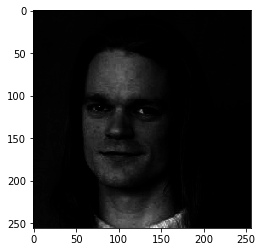

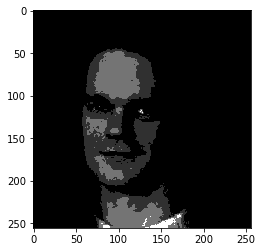

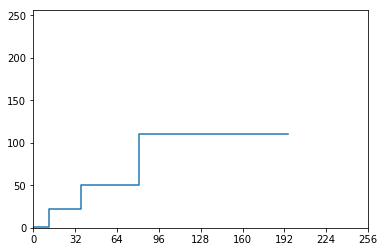

(array([[ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        ..., 
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556]]),
 array([   0.        ,   12.05611917,   36.72547115,   80.44072788,  195.        ]),
 array([   1.47634556,   22.63589279,   50.8150495 ,  110.06640625]))

In [22]:
lloydAlgorithm(bauckhage_gamma_2, levels=4, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.      24.375   48.75    73.125   97.5    121.875  146.25   170.625
  195.   ]
Init Certer Points:  [  12.1875   36.5625   60.9375   85.3125  109.6875  134.0625  158.4375
  182.8125]
Computed Error:  105.472649515

Iteration: 1
Boundaries: [   0.      24.375   48.75    73.125   97.5    121.875  146.25   170.625
  195.   ]
Points: [   2.63519881   34.01763224   58.0003962    81.29218107  108.46753247
  132.23076923  156.66666667  180.36363636]
Computed Error:  25.596306985

Iteration: 2
Boundaries: [   0.           18.32641553   46.00901422   69.64628863   94.87985677
  120.34915085  144.44871795  168.51515152  195.        ]
Points: [   1.96060395   29.4302341    55.31632653   76.09375     103.97777778
  128.66666667  149.          177.71428571]
Computed Error:  18.0599183216

Iteration: 3
Boundaries: [   0.           15.69541902   42.37328031   65.70503827   90.03576389
  116.32222222  138.83333333  163.35714286  195.        ]
Po

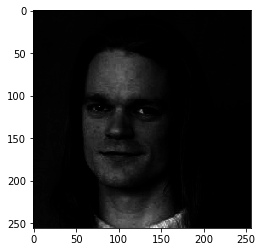

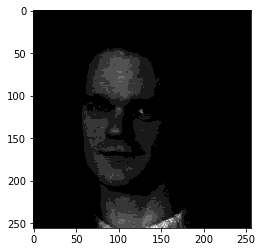

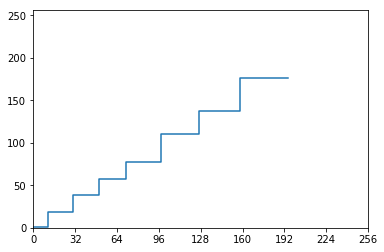

(array([[ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        ..., 
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015],
        [ 1.32693015,  1.32693015,  1.32693015, ...,  1.32693015,
          1.32693015,  1.32693015]]),
 array([   0.        ,   10.96231908,   30.45663437,   50.0662861 ,
          70.89463719,   97.67658638,  126.46413199,  158.08373984,  195.        ]),
 array([   1.32693015,   18.94447608,   38.62104506,   57.94953271,
          77.10837438,  109.98837209,  136.96078431,  176.53333333]))

In [23]:
lloydAlgorithm(bauckhage_gamma_2, levels=8, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.       12.1875   24.375    36.5625   48.75     60.9375   73.125
   85.3125   97.5     109.6875  121.875   134.0625  146.25    158.4375
  170.625   182.8125  195.    ]
Init Certer Points:  [   6.09375   18.28125   30.46875   42.65625   54.84375   67.03125
   79.21875   91.40625  103.59375  115.78125  127.96875  140.15625
  152.34375  164.53125  176.71875  188.90625]
Computed Error:  23.3465487808

Iteration: 1
Boundaries: [   0.       12.1875   24.375    36.5625   48.75     60.9375   73.125
   85.3125   97.5     109.6875  121.875   134.0625  146.25    158.4375
  170.625   182.8125  195.    ]
Points: [   1.47634556   17.27942238   28.87359865   41.70674487   53.84968944
   65.31181619   77.98882682   90.53125     103.04651163  115.32352941
  127.34375     140.05        152.          166.          175.42857143
  189.        ]
Computed Error:  5.95888259542
Final Error : 5.95888259542 Improvement Ratio:  0.744763877035


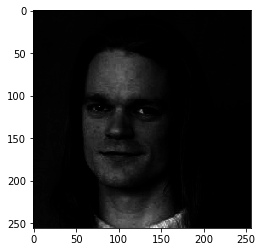

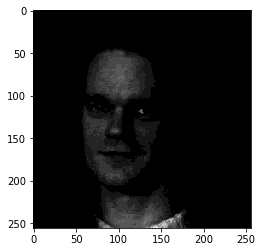

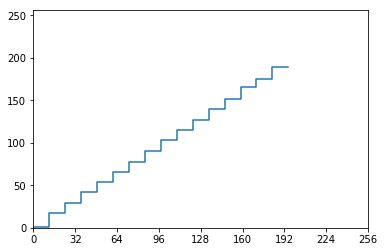

(array([[ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        ..., 
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556],
        [ 1.47634556,  1.47634556,  1.47634556, ...,  1.47634556,
          1.47634556,  1.47634556]]),
 array([   0.    ,   12.1875,   24.375 ,   36.5625,   48.75  ,   60.9375,
          73.125 ,   85.3125,   97.5   ,  109.6875,  121.875 ,  134.0625,
         146.25  ,  158.4375,  170.625 ,  182.8125,  195.    ]),
 array([   1.47634556,   17.27942238,   28.87359865,   41.70674487,
          53.84968944,   65.31181619,   77.98882682,   90.53125   ,
         103.04651163, 

In [24]:
lloydAlgorithm(bauckhage_gamma_2, levels=16, initType=2)

#------ Initilization 
1.0 (256,)
Init Boundaries:  [   0.         6.09375   12.1875    18.28125   24.375     30.46875
   36.5625    42.65625   48.75      54.84375   60.9375    67.03125   73.125
   79.21875   85.3125    91.40625   97.5      103.59375  109.6875
  115.78125  121.875    127.96875  134.0625   140.15625  146.25     152.34375
  158.4375   164.53125  170.625    176.71875  182.8125   188.90625  195.     ]
Init Certer Points:  [   3.046875    9.140625   15.234375   21.328125   27.421875   33.515625
   39.609375   45.703125   51.796875   57.890625   63.984375   70.078125
   76.171875   82.265625   88.359375   94.453125  100.546875  106.640625
  112.734375  118.828125  124.921875  131.015625  137.109375  143.203125
  149.296875  155.390625  161.484375  167.578125  173.671875  179.765625
  185.859375  191.953125]
Computed Error:  5.20204299316

Iteration: 1
Boundaries: [   0.         6.09375   12.1875    18.28125   24.375     30.46875
   36.5625    42.65625   48.75      54.84375  

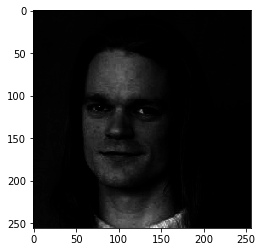

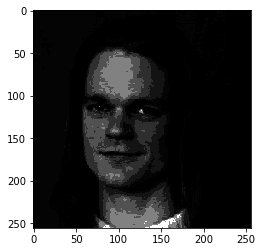

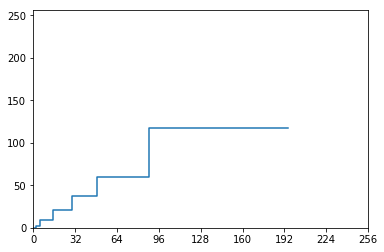

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.97729807,  1.97729807,  1.97729807, ...,  0.        ,
          0.        ,  0.        ]]),
 array([   0.        ,    1.58117961,    1.9948518 ,    1.93195629,
           1.93195629,    1.9948518 ,    1.9948518 ,    1.9948518 ,
           1.9948518 ,    1.9948518 ,    1.93195629,    1.93195629,
           1.93195629,    1.93195629,    1.93195629,    1.9948518 ,
           1.9948518 ,    1.9948518 ,    1.9948518 ,    1.9948518 ,
           1.9948518 ,    1.9319

In [25]:
lloydAlgorithm(bauckhage_gamma_2, levels=32, initType=2, maxIterations=200, errorThreshold=1., improveThreshold=0.0001)